# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

In [12]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from importlib import reload
import utils2; reload(utils2)
from utils2 import *

In [16]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [17]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

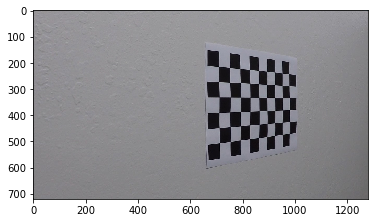

In [18]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [19]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [20]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [21]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

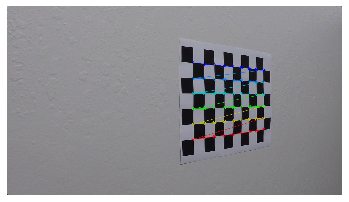

In [22]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [23]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [24]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [25]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

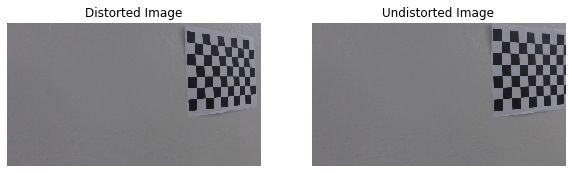

In [26]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

We can see that the undistortion step indeed works well. Let's apply the undistortion step to our test images.

#### Undistorting Test Images

In [126]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [127]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [128]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [129]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

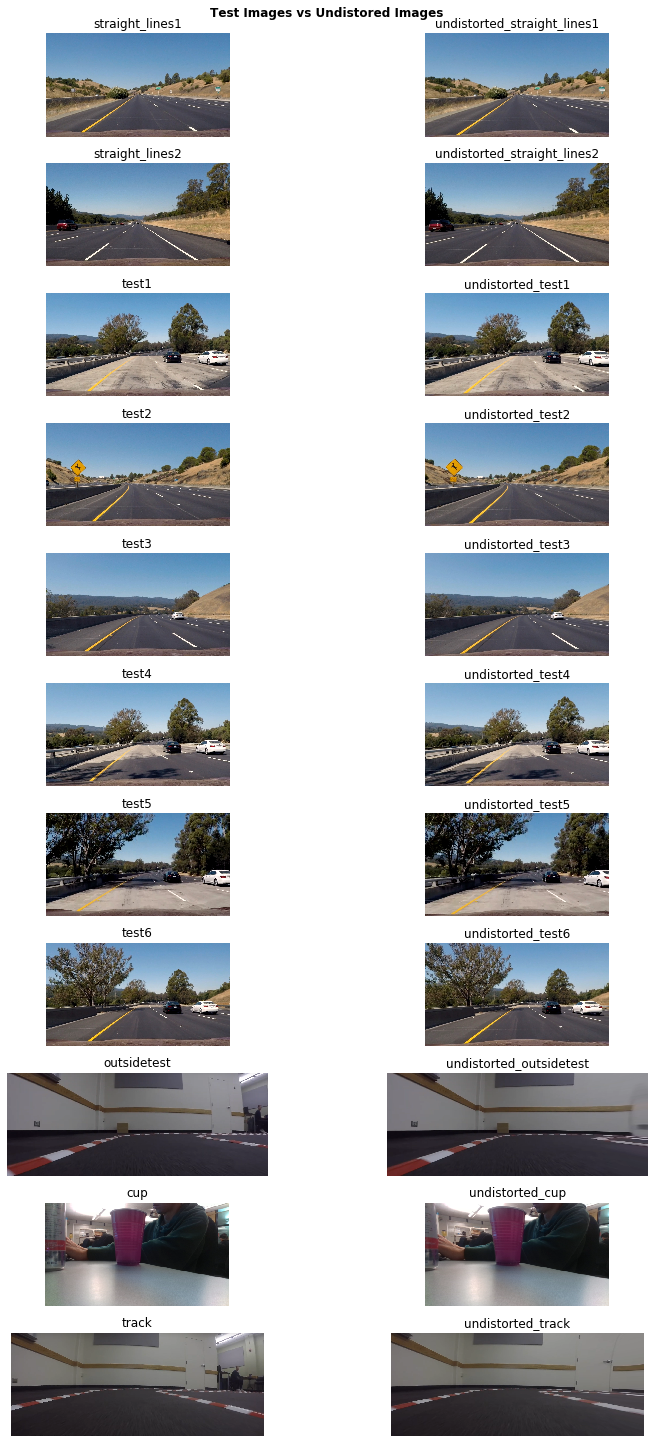

In [130]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images. We can see that on the undistorted images, the front of the car, especially at the sides, is less visible.

## Thresholding

We apply color and edge  thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later. 

We start with first exploring which color spaces we should adopt to increase our chances of detecting the lanes and facilitating the task of the gradient thresholding step.

In [131]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [132]:
test_img_path

'test_images/outsidetest.jpg'

In [184]:
test_img_path = test_imgs_paths[9]
test_img = load_image(test_img_path)
outside_test_img_path = test_imgs_paths[8]
outside_test_img = load_image(outside_test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)
undistorted_outside_test_img = undistort_image(outside_test_img, opts, ipts)

error: OpenCV(4.2.0) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [185]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [186]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [187]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [188]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [189]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

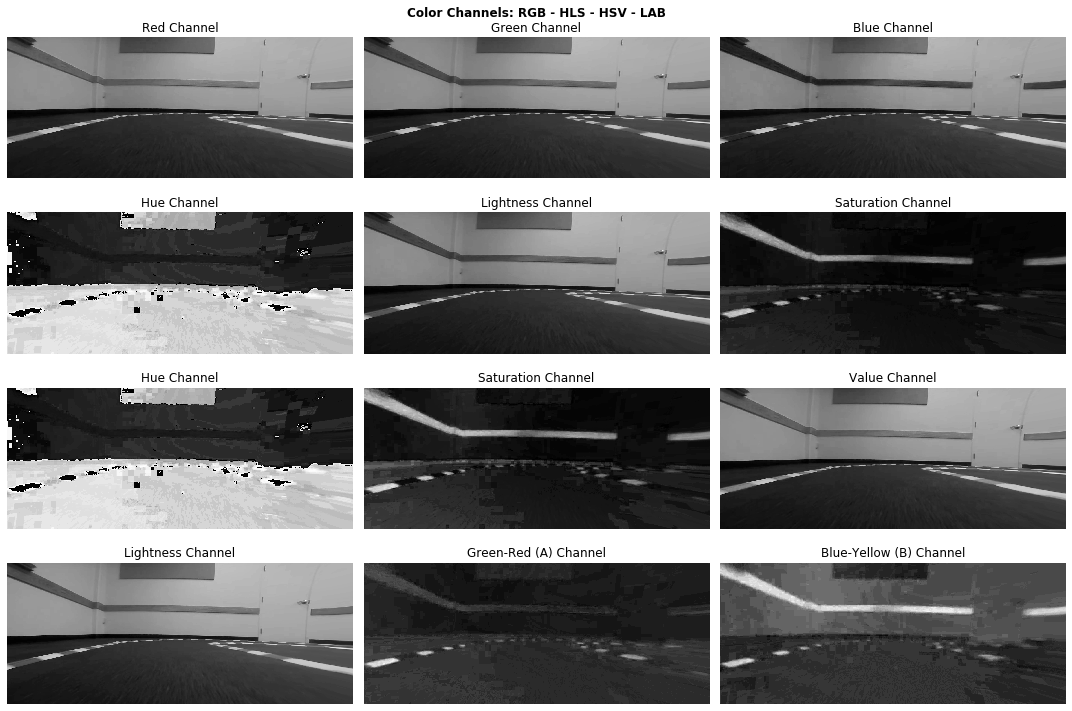

In [190]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

On the RGB components, we see that the blue channel is worst at identifying yellow lines, while the red channel seems to give best results.

For HLS and HSV, the hue channel produces an extremely noisy output, while the saturation channel of HLS seems to give the strong results; better than HSV's saturation channel. conversely, HSV's value channel is giving a very clear grayscale-ish image, especially on the yellow line, much better than HLS' lightness channel.

Lastly, LAB's A channel is not doing a great job, while it's B channel is strong at identifying the yellow line. But it is the lightness channel that shines (no pun intended) at identify both yellow and white lines.

At this stage, we are faced with various choices that have pros and cons. Our goal here is to find the right thresholds on a given color channel to highlight yellow and white lines of the lane. There are actually many ways we could achieve this result, but **we choose to use HLS because we already know how to set thresholds for yellow and white lane lines from [Project 1](https://github.com/kenshiro-o/CarND-LaneLines-P1)** .

In [191]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

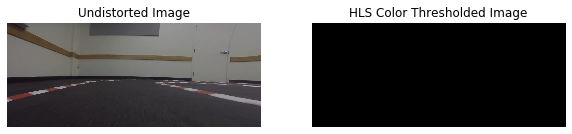

In [192]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

As you can see above, our HLS color thresholding achieve great results on the image. The thresholding somewhat struggles a little with the shadow of the tree on the yellow line further up ahead. We believe gradient thresholding can help in this case.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

We have decided to use LAB's L channel as our single-channel image to serve as input to the sobel functions below.

In [193]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [194]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [195]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [196]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

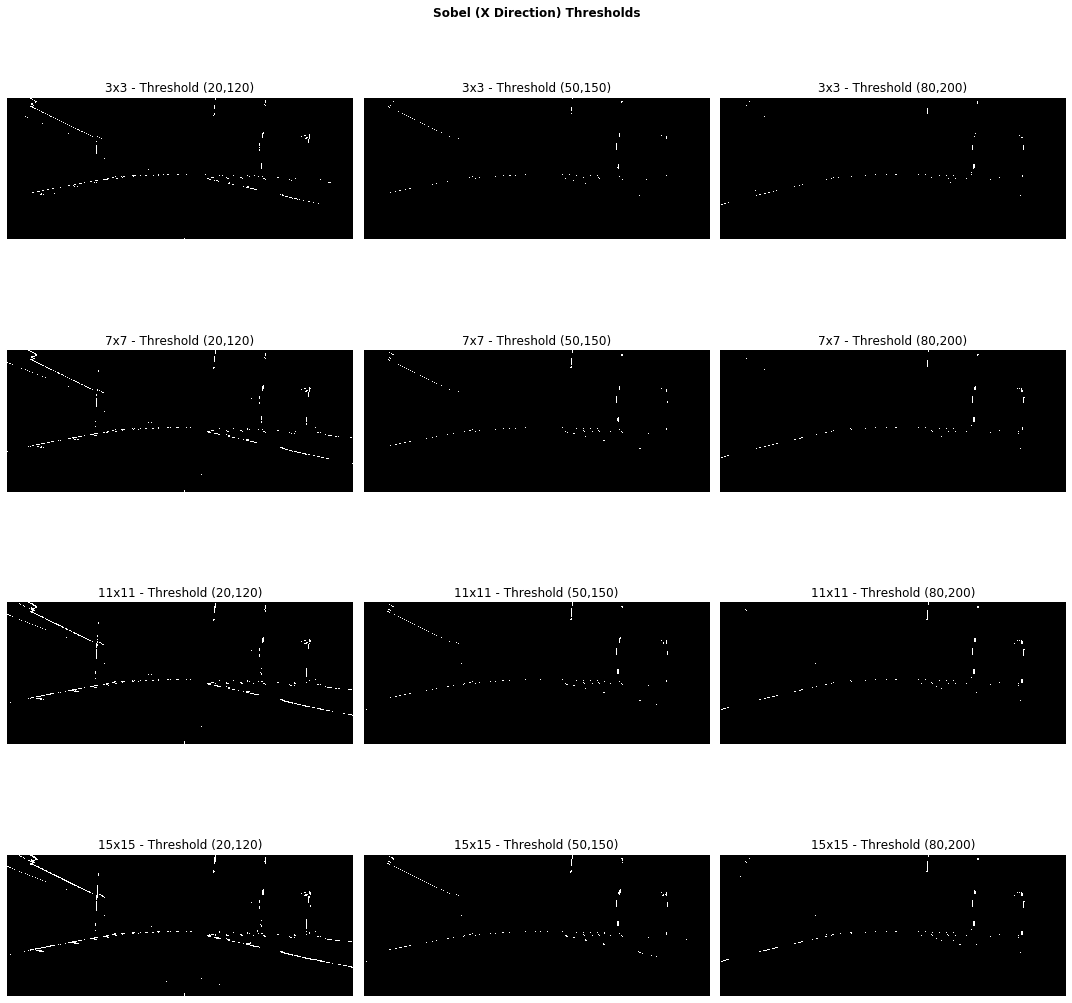

In [197]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [198]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [199]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [200]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

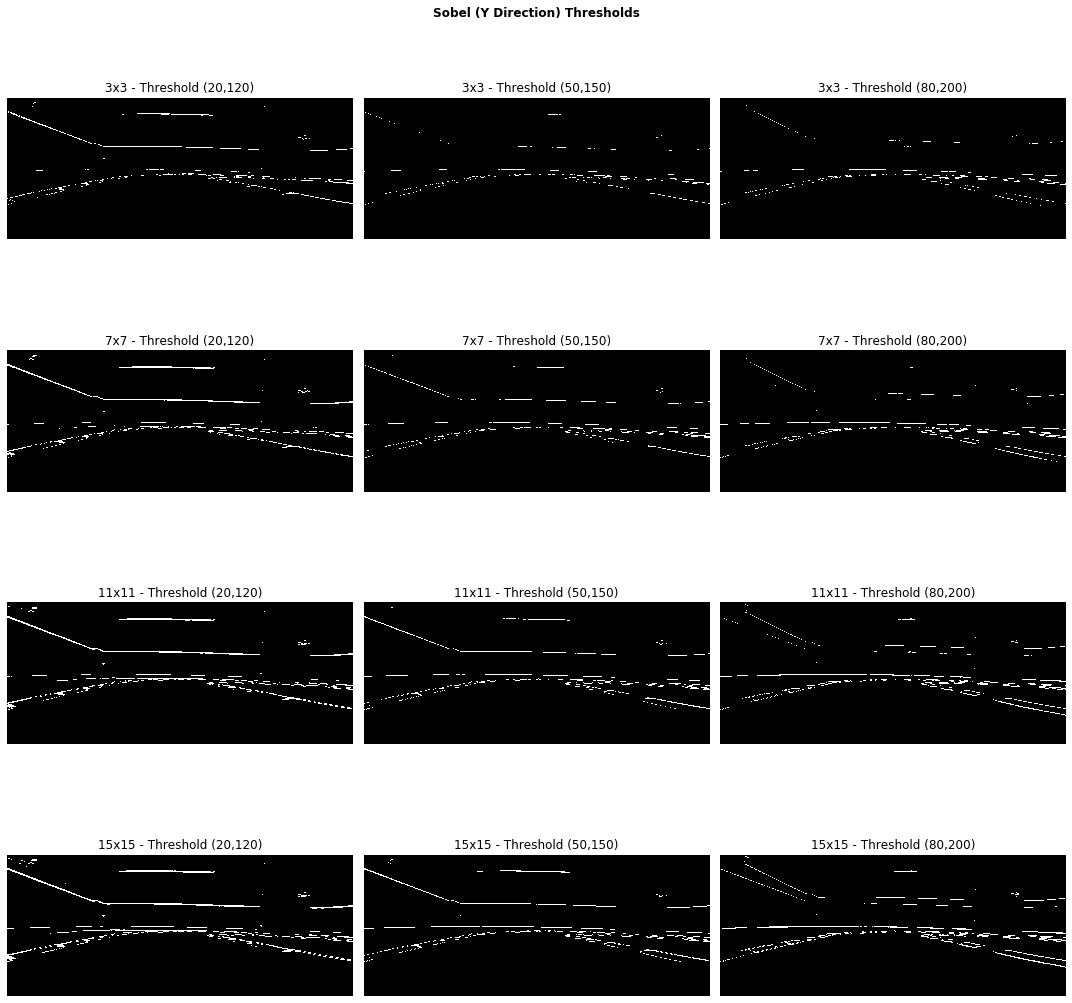

In [201]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [202]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [203]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [204]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [205]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


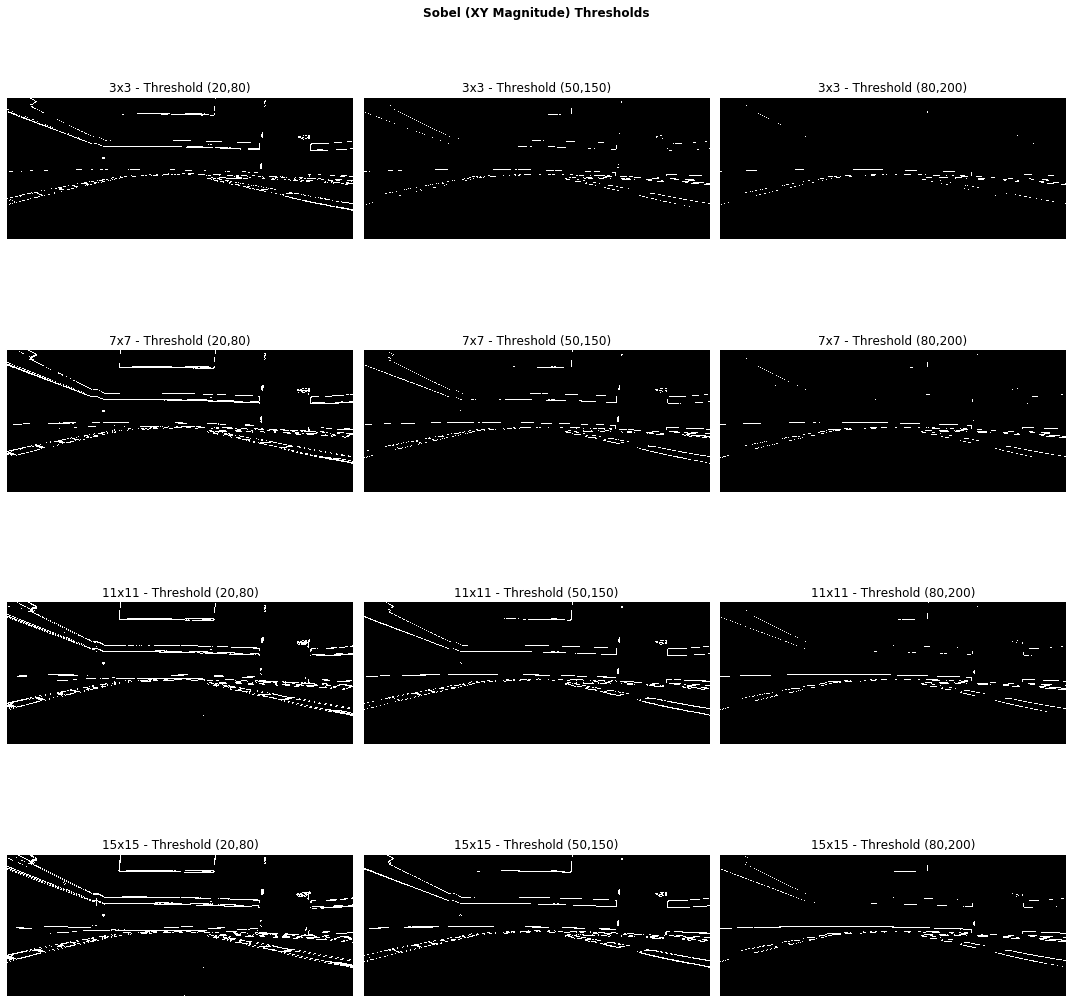

In [206]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [207]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [208]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [209]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [210]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [211]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [212]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

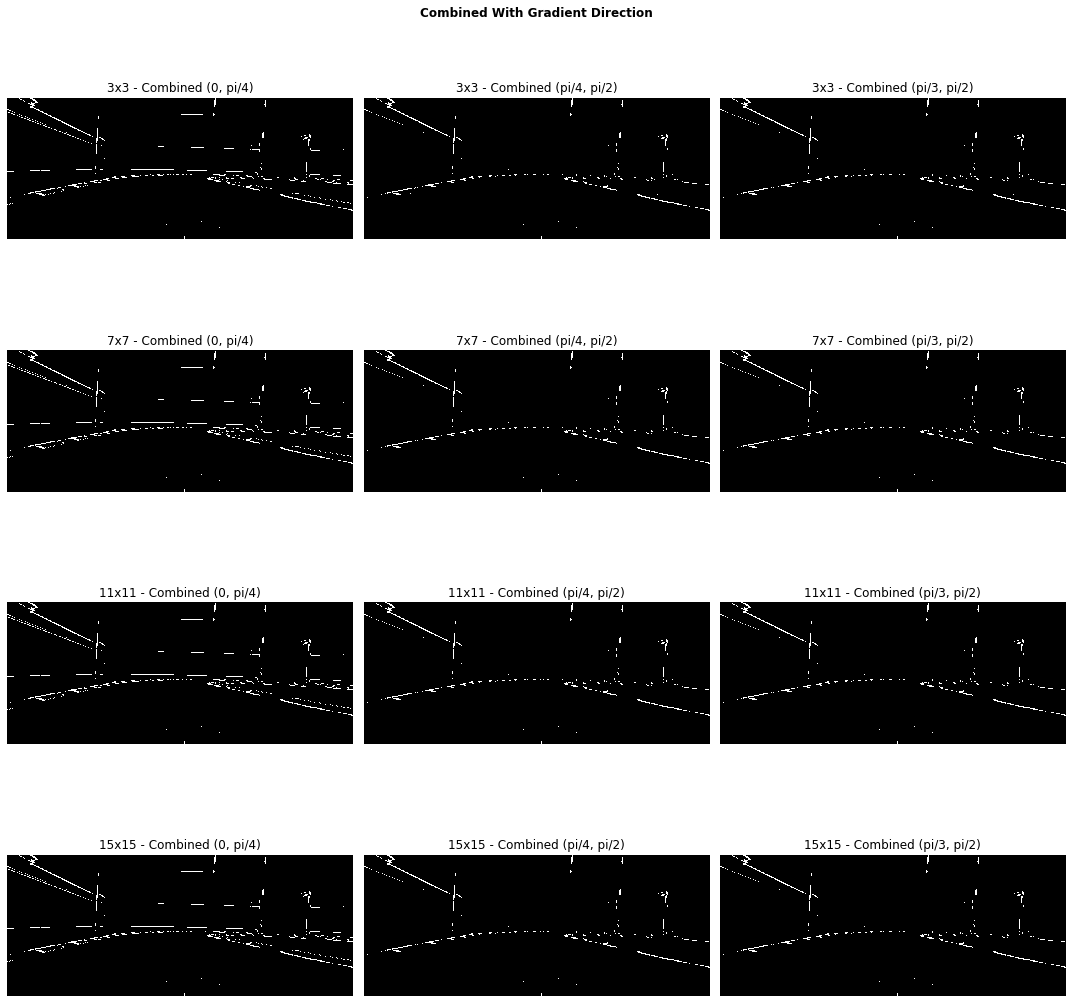

In [213]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [214]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. We should next combine it with the results we obtained from our HLS' color thresholding method.

### Combining Color And Gradient (Sobel) Thresholds

In [215]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [216]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [217]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

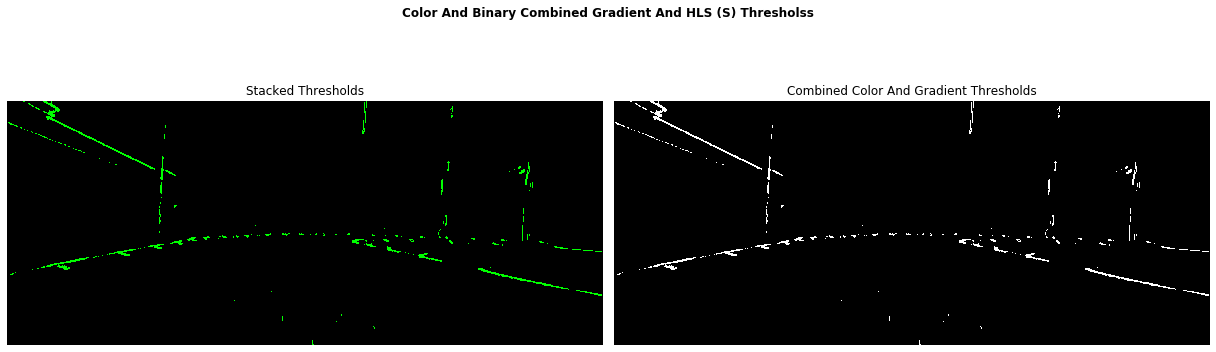

In [218]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

The results are very encouraging and it seems we have found the right parameters to detect lanes in a robust manner. We turn next to applying a perspective transform to our image and produce a _bird's eye view_ of the lane.

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

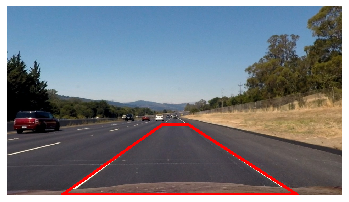

In [255]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [220]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [221]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [222]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [223]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

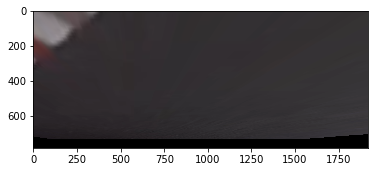

In [224]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [228]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

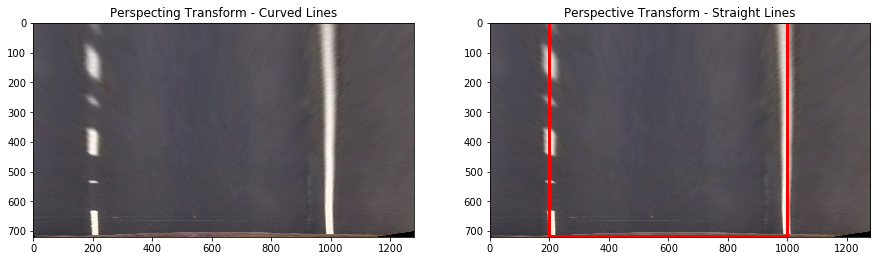

In [243]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[1])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

We can see that our perspective transform keeps straight lines straight, which is a required sanity check. The curved lines however are not perfect on the example above, but they should not cause unsurmountable problems for our algorithm either. 

In [256]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

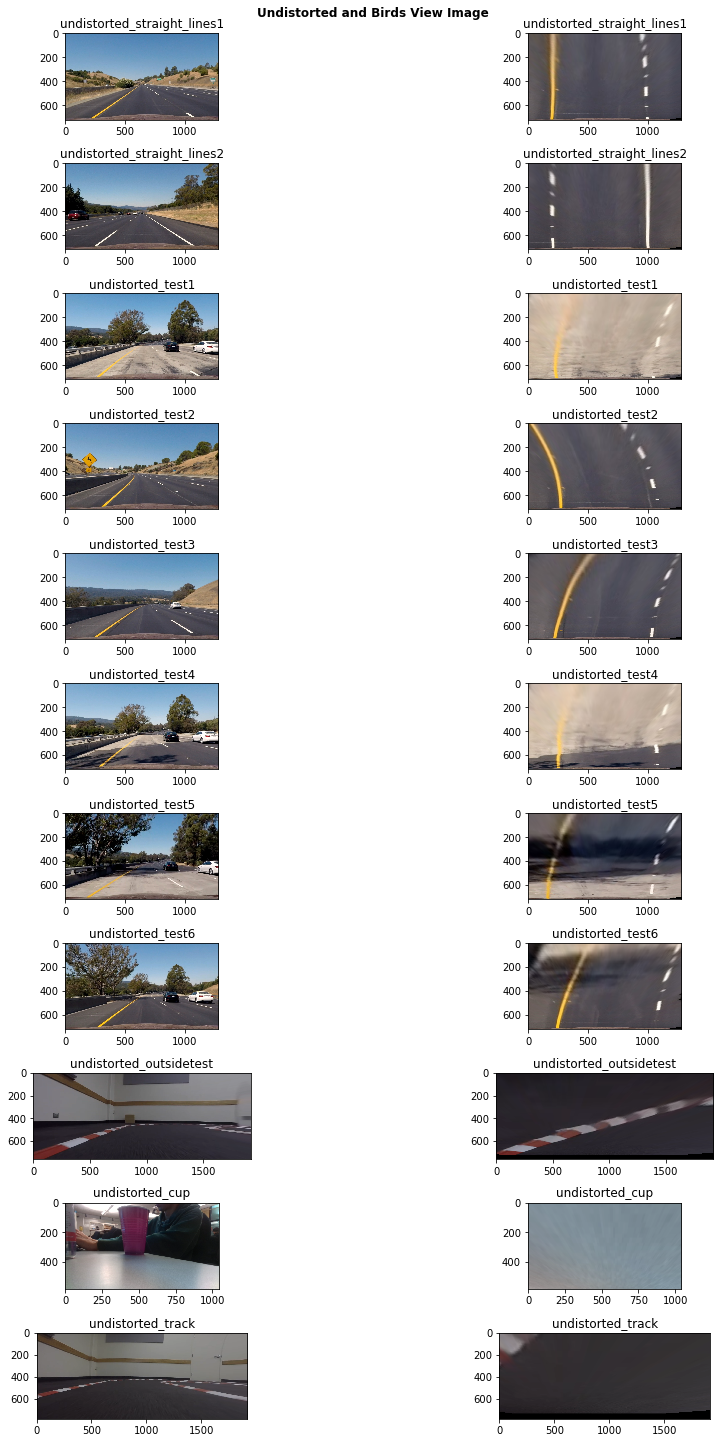

In [257]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

### Putting It All Together

In [258]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [259]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [260]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [261]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [262]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

IndexError: too many indices for array

In [ ]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

NameError: name 'test_imgs_combined_binary_and_psp_tr' is not defined

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

In [183]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

NameError: name 'test_imgs_combined_binary_and_psp_tr' is not defined

# Pipeline Definition

Let's now define our full pipeline for lane detection on video frames. We will use Python classes to encapsulate a information and use it across frames. 

In [72]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [73]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [74]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [95]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        # print(ploty * self.ym_per_px, leftx * self.xm_per_px)
        # print(ploty * self.ym_per_px.shape[0], leftx * self.xm_per_px.shape[0])
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [96]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [97]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=31891.070517716817
Left Curvature   Right Curvature  Center Alignment 
1003.8011m       2518.4605m       0.1711m Right    


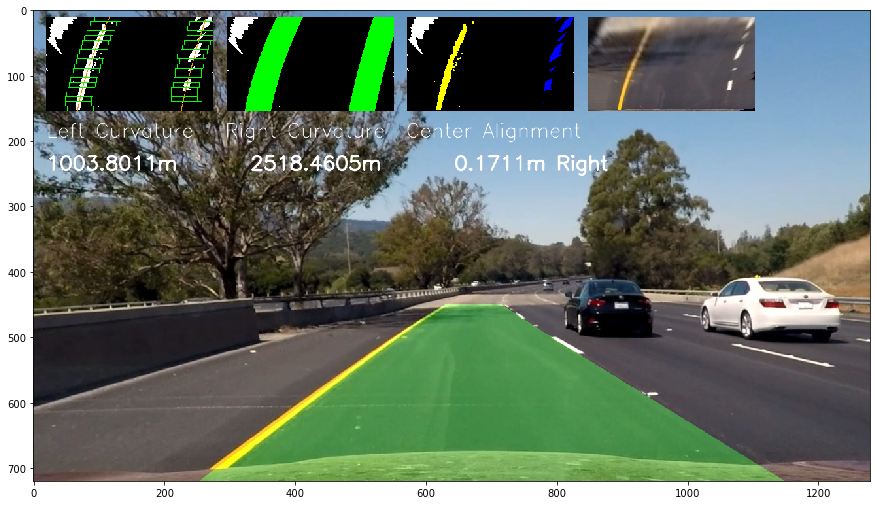

In [98]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

In [99]:
#(720, 1280, 3)

# Normal video

In [111]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [112]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [113]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [114]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    
Moviepy - Building video output_videos/lanes_project_video_sample.mp4.
Moviepy - Writing video output_videos/lanes_project_video_sample.mp4



t:   1%|▏         | 2/136 [00:01<01:08,  1.96it/s, now=None]

[Previous lane] Found pct=0.8019734493167581
Non zeros found below thresholds, begining sliding window - pct=0.8019734493167581
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    


t:   2%|▏         | 3/136 [00:02<01:52,  1.18it/s, now=None]

[Previous lane] Found pct=0.7846561444887805
Non zeros found below thresholds, begining sliding window - pct=0.7846561444887805
[Sliding windows] Found pct=21634.31329057689
Left Curvature   Right Curvature  Center Alignment 
6070.4331m       7405.9791m       0.0875m Right    


t:   3%|▎         | 4/136 [00:03<02:10,  1.01it/s, now=None]

[Previous lane] Found pct=0.7857179998266748
Non zeros found below thresholds, begining sliding window - pct=0.7857179998266748
[Sliding windows] Found pct=19927.02223762891
Left Curvature   Right Curvature  Center Alignment 
2165.4155m       6032.1863m       0.0882m Right    


t:   4%|▎         | 5/136 [00:04<02:24,  1.10s/it, now=None]

[Previous lane] Found pct=0.7781293437705757
Non zeros found below thresholds, begining sliding window - pct=0.7781293437705757
[Sliding windows] Found pct=18472.820085595144
Left Curvature   Right Curvature  Center Alignment 
2912.2983m       5579.3115m       0.0877m Right    


t:   4%|▍         | 6/136 [00:05<02:16,  1.05s/it, now=None]

[Previous lane] Found pct=0.7764292032667504
Non zeros found below thresholds, begining sliding window - pct=0.7764292032667504
[Sliding windows] Found pct=16467.064100717944
Left Curvature   Right Curvature  Center Alignment 
4354.8537m       924.7667m        0.0514m Right    


t:   5%|▌         | 7/136 [00:06<02:10,  1.01s/it, now=None]

[Previous lane] Found pct=0.7756889943420332
Non zeros found below thresholds, begining sliding window - pct=0.7756889943420332
[Sliding windows] Found pct=16822.581898562188
Left Curvature   Right Curvature  Center Alignment 
6642.9587m       2534.8131m       0.0874m Right    


t:   6%|▌         | 8/136 [00:07<02:10,  1.02s/it, now=None]

[Previous lane] Found pct=0.7226362011937801
Non zeros found below thresholds, begining sliding window - pct=0.7226362011937801
[Sliding windows] Found pct=16634.91413526974
Left Curvature   Right Curvature  Center Alignment 
2013.6486m       17406.3146m      0.0971m Right    


t:   7%|▋         | 9/136 [00:08<02:03,  1.02it/s, now=None]

[Previous lane] Found pct=0.7050582073254243
Non zeros found below thresholds, begining sliding window - pct=0.7050582073254243
[Sliding windows] Found pct=17493.833558512706
Left Curvature   Right Curvature  Center Alignment 
1399.1388m       7558.4907m       0.0871m Right    


t:   7%|▋         | 10/136 [00:09<01:58,  1.06it/s, now=None]

[Previous lane] Found pct=0.7464674519026091
Non zeros found below thresholds, begining sliding window - pct=0.7464674519026091
[Sliding windows] Found pct=17065.058994060048
Left Curvature   Right Curvature  Center Alignment 
1721.9458m       2242.8519m       0.0795m Right    


t:   8%|▊         | 11/136 [00:10<01:56,  1.07it/s, now=None]

[Previous lane] Found pct=0.6023710095592456
Non zeros found below thresholds, begining sliding window - pct=0.6023710095592456
[Sliding windows] Found pct=17759.681497021393
Left Curvature   Right Curvature  Center Alignment 
1973.8719m       1454.2940m       0.0893m Right    


t:   9%|▉         | 12/136 [00:11<01:56,  1.06it/s, now=None]

[Previous lane] Found pct=0.7811436617514765
Non zeros found below thresholds, begining sliding window - pct=0.7811436617514765
[Sliding windows] Found pct=18391.03009739117
Left Curvature   Right Curvature  Center Alignment 
2164.0387m       1564.4567m       0.0842m Right    


t:  10%|▉         | 13/136 [00:12<01:56,  1.05it/s, now=None]

[Previous lane] Found pct=0.8089391162695989
Non zeros found below thresholds, begining sliding window - pct=0.8089391162695989
[Sliding windows] Found pct=18571.66621869273
Left Curvature   Right Curvature  Center Alignment 
1678.3753m       1195.7256m       0.1080m Right    


t:  10%|█         | 14/136 [00:13<01:57,  1.04it/s, now=None]

[Previous lane] Found pct=0.618105451676865
Non zeros found below thresholds, begining sliding window - pct=0.618105451676865
[Sliding windows] Found pct=18235.652239728803
Left Curvature   Right Curvature  Center Alignment 
3148.3393m       18824.0682m      0.1055m Right    


t:  11%|█         | 15/136 [00:14<01:53,  1.07it/s, now=None]

[Previous lane] Found pct=0.7653396324249583
Non zeros found below thresholds, begining sliding window - pct=0.7653396324249583
[Sliding windows] Found pct=13822.382007259319
Left Curvature   Right Curvature  Center Alignment 
1150.9530m       1522.2642m       0.1041m Right    


t:  12%|█▏        | 16/136 [00:15<01:52,  1.07it/s, now=None]

[Previous lane] Found pct=0.7590167046317388
Non zeros found below thresholds, begining sliding window - pct=0.7590167046317388
[Sliding windows] Found pct=12929.003669956974
Left Curvature   Right Curvature  Center Alignment 
1463.6256m       1064.1929m       0.0597m Right    


t:  12%|█▎        | 17/136 [00:16<01:51,  1.07it/s, now=None]

[Previous lane] Found pct=0.7805129761724086
Non zeros found below thresholds, begining sliding window - pct=0.7805129761724086
[Sliding windows] Found pct=13737.216482015481
Left Curvature   Right Curvature  Center Alignment 
5257.5290m       2723.3597m       0.0999m Right    


t:  13%|█▎        | 18/136 [00:17<01:50,  1.07it/s, now=None]

[Previous lane] Found pct=0.8843864229765013
Left Curvature   Right Curvature  Center Alignment 
122568.3901m     2574.4965m       0.0972m Right    


t:  14%|█▍        | 19/136 [00:18<01:50,  1.06it/s, now=None]

[Previous lane] Found pct=0.9040371329879102
Left Curvature   Right Curvature  Center Alignment 
1686.9690m       4154.5385m       0.1062m Right    


t:  15%|█▍        | 20/136 [00:18<01:46,  1.09it/s, now=None]

[Previous lane] Found pct=0.8927605409705648
Left Curvature   Right Curvature  Center Alignment 
1603.5979m       3038.3028m       0.1059m Right    


t:  15%|█▌        | 21/136 [00:19<01:43,  1.11it/s, now=None]

[Previous lane] Found pct=0.8806782499476659
Left Curvature   Right Curvature  Center Alignment 
1478.2044m       4900.5986m       0.1136m Right    


t:  16%|█▌        | 22/136 [00:20<01:41,  1.12it/s, now=None]

[Previous lane] Found pct=0.8453849111288557
Non zeros found below thresholds, begining sliding window - pct=0.8453849111288557
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    


t:  17%|█▋        | 23/136 [00:21<01:40,  1.12it/s, now=None]

[Previous lane] Found pct=0.8810690677000228
Left Curvature   Right Curvature  Center Alignment 
1147.7139m       2864.4256m       0.1005m Right    


t:  18%|█▊        | 24/136 [00:22<01:39,  1.13it/s, now=None]

[Previous lane] Found pct=0.8897537911549328
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3063.2815m       0.1040m Right    


t:  18%|█▊        | 25/136 [00:23<01:37,  1.13it/s, now=None]

[Previous lane] Found pct=0.8842374520385563
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3284.8537m       0.1144m Right    


t:  19%|█▉        | 26/136 [00:24<01:43,  1.06it/s, now=None]

[Previous lane] Found pct=0.870750600412678
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3813.9553m       0.1178m Right    


t:  20%|█▉        | 27/136 [00:25<01:41,  1.08it/s, now=None]

[Previous lane] Found pct=0.8607212123204365
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


t:  21%|██        | 28/136 [00:26<01:38,  1.09it/s, now=None]

[Previous lane] Found pct=0.8931860036832413
Left Curvature   Right Curvature  Center Alignment 
1252.9051m       2891.3311m       0.1801m Right    


t:  21%|██▏       | 29/136 [00:26<01:37,  1.10it/s, now=None]

[Previous lane] Found pct=0.8916472991055708
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


t:  22%|██▏       | 30/136 [00:27<01:34,  1.12it/s, now=None]

[Previous lane] Found pct=0.8936295373542337
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.7234m        0.2119m Right    


t:  23%|██▎       | 31/136 [00:28<01:36,  1.09it/s, now=None]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


t:  24%|██▎       | 32/136 [00:29<01:42,  1.01it/s, now=None]

[Previous lane] Found pct=0.9044788197578512
Left Curvature   Right Curvature  Center Alignment 
3400.8444m       751.7638m        0.2190m Right    


t:  24%|██▍       | 33/136 [00:30<01:39,  1.04it/s, now=None]

[Previous lane] Found pct=0.8900625848538031
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.5019m        0.1940m Right    


t:  25%|██▌       | 34/136 [00:31<01:37,  1.05it/s, now=None]

[Previous lane] Found pct=0.8914877427465511
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


t:  26%|██▌       | 35/136 [00:32<01:35,  1.06it/s, now=None]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


t:  26%|██▋       | 36/136 [00:33<01:33,  1.07it/s, now=None]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


t:  27%|██▋       | 37/136 [00:34<01:30,  1.09it/s, now=None]

[Previous lane] Found pct=0.8949881525095139
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


t:  28%|██▊       | 38/136 [00:35<01:29,  1.10it/s, now=None]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


t:  29%|██▊       | 39/136 [00:36<01:27,  1.10it/s, now=None]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


t:  29%|██▉       | 40/136 [00:37<01:27,  1.10it/s, now=None]

[Previous lane] Found pct=0.8909268219496643
Left Curvature   Right Curvature  Center Alignment 
560.5807m        1701.5025m       0.1011m Right    


t:  30%|███       | 41/136 [00:38<01:27,  1.09it/s, now=None]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


t:  31%|███       | 42/136 [00:39<01:26,  1.09it/s, now=None]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8815m        393.6282m        0.1525m Right    


t:  32%|███▏      | 43/136 [00:40<01:26,  1.08it/s, now=None]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


t:  32%|███▏      | 44/136 [00:40<01:24,  1.08it/s, now=None]

[Previous lane] Found pct=0.8305501337381623
Non zeros found below thresholds, begining sliding window - pct=0.8305501337381623
[Sliding windows] Found pct=11640.069977589821
Left Curvature   Right Curvature  Center Alignment 
411.9685m        6439.7173m       0.0427m Right    


t:  33%|███▎      | 45/136 [00:41<01:24,  1.07it/s, now=None]

[Previous lane] Found pct=0.8433968356474008
Non zeros found below thresholds, begining sliding window - pct=0.8433968356474008
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


t:  34%|███▍      | 46/136 [00:42<01:22,  1.09it/s, now=None]

[Previous lane] Found pct=0.9050070700844784
Left Curvature   Right Curvature  Center Alignment 
2508.2517m       2731.0525m       0.0577m Right    


t:  35%|███▍      | 47/136 [00:43<01:21,  1.09it/s, now=None]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


t:  35%|███▌      | 48/136 [00:44<01:19,  1.11it/s, now=None]

[Previous lane] Found pct=0.8945586839607719
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1961.5402m       0.0648m Right    


t:  36%|███▌      | 49/136 [00:45<01:18,  1.11it/s, now=None]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


t:  37%|███▋      | 50/136 [00:46<01:18,  1.10it/s, now=None]

[Previous lane] Found pct=0.861794183690235
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


t:  38%|███▊      | 51/136 [00:47<01:17,  1.10it/s, now=None]

[Previous lane] Found pct=0.9050269458432724
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


t:  38%|███▊      | 52/136 [00:48<01:17,  1.09it/s, now=None]

[Previous lane] Found pct=0.8600712773654171
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.1255m        0.1301m Right    


t:  39%|███▉      | 53/136 [00:49<01:21,  1.02it/s, now=None]

[Previous lane] Found pct=0.9002798968223479
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


t:  40%|███▉      | 54/136 [00:50<01:18,  1.04it/s, now=None]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


t:  40%|████      | 55/136 [00:51<01:18,  1.03it/s, now=None]

[Previous lane] Found pct=0.8948421821329078
Left Curvature   Right Curvature  Center Alignment 
1421.2413m       368.0198m        0.1586m Right    


t:  41%|████      | 56/136 [00:52<01:18,  1.02it/s, now=None]

[Previous lane] Found pct=0.8476263820892238
Non zeros found below thresholds, begining sliding window - pct=0.8476263820892238
[Sliding windows] Found pct=16479.815473898456
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


t:  42%|████▏     | 57/136 [00:53<01:17,  1.02it/s, now=None]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


t:  43%|████▎     | 58/136 [00:54<01:17,  1.00it/s, now=None]

[Previous lane] Found pct=0.9540822009356204
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


t:  43%|████▎     | 59/136 [00:55<01:13,  1.04it/s, now=None]

[Previous lane] Found pct=0.9190463917525773
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


t:  44%|████▍     | 60/136 [00:56<01:11,  1.06it/s, now=None]

[Previous lane] Found pct=0.9170067688632292
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5665m        0.0442m Right    


t:  45%|████▍     | 61/136 [00:57<01:10,  1.06it/s, now=None]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


t:  46%|████▌     | 62/136 [00:57<01:08,  1.09it/s, now=None]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


t:  46%|████▋     | 63/136 [00:58<01:06,  1.09it/s, now=None]

[Previous lane] Found pct=0.904247928142524
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


t:  47%|████▋     | 64/136 [00:59<01:05,  1.10it/s, now=None]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


t:  48%|████▊     | 65/136 [01:00<01:05,  1.09it/s, now=None]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


t:  49%|████▊     | 66/136 [01:01<01:04,  1.09it/s, now=None]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


t:  49%|████▉     | 67/136 [01:02<01:03,  1.09it/s, now=None]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


t:  50%|█████     | 68/136 [01:03<01:03,  1.07it/s, now=None]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


t:  51%|█████     | 69/136 [01:04<01:02,  1.06it/s, now=None]

[Previous lane] Found pct=0.9332370371943837
Left Curvature   Right Curvature  Center Alignment 
329.9316m        531.3374m        0.0839m Left     


t:  51%|█████▏    | 70/136 [01:05<01:01,  1.08it/s, now=None]

[Previous lane] Found pct=0.8982973049769404
Left Curvature   Right Curvature  Center Alignment 
328.5377m        469.6804m        0.0854m Left     


t:  52%|█████▏    | 71/136 [01:06<00:59,  1.10it/s, now=None]

[Previous lane] Found pct=0.942516385516278
Left Curvature   Right Curvature  Center Alignment 
320.7352m        487.0053m        0.0846m Left     


t:  53%|█████▎    | 72/136 [01:07<01:00,  1.06it/s, now=None]

[Previous lane] Found pct=0.9472951597595698
Left Curvature   Right Curvature  Center Alignment 
320.4712m        459.3909m        0.0838m Left     


t:  54%|█████▎    | 73/136 [01:08<00:58,  1.07it/s, now=None]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


t:  54%|█████▍    | 74/136 [01:09<00:57,  1.07it/s, now=None]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


t:  55%|█████▌    | 75/136 [01:09<00:57,  1.07it/s, now=None]

[Previous lane] Found pct=0.9638667484161046
Left Curvature   Right Curvature  Center Alignment 
372.6083m        604.5288m        0.0764m Left     


t:  56%|█████▌    | 76/136 [01:10<00:55,  1.08it/s, now=None]

[Previous lane] Found pct=0.7356095033086184
Non zeros found below thresholds, begining sliding window - pct=0.7356095033086184
[Sliding windows] Found pct=23119.80291796221
Left Curvature   Right Curvature  Center Alignment 
317.9777m        423.6703m        0.0434m Left     


t:  57%|█████▋    | 77/136 [01:11<00:54,  1.07it/s, now=None]

[Previous lane] Found pct=0.8605465331129047
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.6810m        0.0307m Left     


t:  57%|█████▋    | 78/136 [01:12<00:54,  1.06it/s, now=None]

[Previous lane] Found pct=0.8790518024840958
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7297m        0.0211m Left     


t:  58%|█████▊    | 79/136 [01:13<00:53,  1.07it/s, now=None]

[Previous lane] Found pct=0.8465337132003798
Non zeros found below thresholds, begining sliding window - pct=0.8465337132003798
[Sliding windows] Found pct=23368.788698955366
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


t:  59%|█████▉    | 80/136 [01:14<00:51,  1.08it/s, now=None]

[Previous lane] Found pct=0.8194405643246263
Non zeros found below thresholds, begining sliding window - pct=0.8194405643246263
[Sliding windows] Found pct=25262.996944405644
Left Curvature   Right Curvature  Center Alignment 
381.3755m        319.6393m        0.0546m Right    


t:  60%|█████▉    | 81/136 [01:15<00:51,  1.07it/s, now=None]

[Previous lane] Found pct=0.7941749427043545
Non zeros found below thresholds, begining sliding window - pct=0.7941749427043545
[Sliding windows] Found pct=25051.930939648588
Left Curvature   Right Curvature  Center Alignment 
462.8301m        426.1410m        0.0382m Right    


t:  60%|██████    | 82/136 [01:16<00:50,  1.07it/s, now=None]

[Previous lane] Found pct=0.8971990081733859
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


t:  61%|██████    | 83/136 [01:17<00:48,  1.09it/s, now=None]

[Previous lane] Found pct=0.9197869740465812
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.9927m        0.0126m Left     


t:  62%|██████▏   | 84/136 [01:18<00:47,  1.09it/s, now=None]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


t:  62%|██████▎   | 85/136 [01:19<00:47,  1.06it/s, now=None]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


t:  63%|██████▎   | 86/136 [01:20<00:46,  1.07it/s, now=None]

[Previous lane] Found pct=0.8714200267398494
Left Curvature   Right Curvature  Center Alignment 
725.9496m        459.7047m        0.0121m Left     


t:  64%|██████▍   | 87/136 [01:21<00:44,  1.09it/s, now=None]

[Previous lane] Found pct=0.769010727056019
Non zeros found below thresholds, begining sliding window - pct=0.769010727056019
[Sliding windows] Found pct=26898.377217776266
Left Curvature   Right Curvature  Center Alignment 
568.2713m        379.0922m        0.0108m Right    


t:  65%|██████▍   | 88/136 [01:21<00:43,  1.10it/s, now=None]

[Previous lane] Found pct=0.7958049119470402
Non zeros found below thresholds, begining sliding window - pct=0.7958049119470402
[Sliding windows] Found pct=24807.3956256972
Left Curvature   Right Curvature  Center Alignment 
515.8677m        312.4867m        0.0269m Right    


t:  65%|██████▌   | 89/136 [01:22<00:42,  1.11it/s, now=None]

[Previous lane] Found pct=0.8852340725096797
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


t:  66%|██████▌   | 90/136 [01:23<00:40,  1.12it/s, now=None]

[Previous lane] Found pct=0.9223574927237879
Left Curvature   Right Curvature  Center Alignment 
594.8159m        348.1265m        0.0427m Right    


t:  67%|██████▋   | 91/136 [01:24<00:40,  1.12it/s, now=None]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


t:  68%|██████▊   | 92/136 [01:25<00:39,  1.12it/s, now=None]

[Previous lane] Found pct=0.8029836688699397
Non zeros found below thresholds, begining sliding window - pct=0.8029836688699397
[Sliding windows] Found pct=28188.45971037893
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


t:  68%|██████▊   | 93/136 [01:26<00:38,  1.12it/s, now=None]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


t:  69%|██████▉   | 94/136 [01:27<00:37,  1.11it/s, now=None]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


t:  70%|██████▉   | 95/136 [01:28<00:37,  1.09it/s, now=None]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


t:  71%|███████   | 96/136 [01:29<00:36,  1.10it/s, now=None]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


t:  71%|███████▏  | 97/136 [01:30<00:35,  1.10it/s, now=None]

[Previous lane] Found pct=0.9736528833024054
Left Curvature   Right Curvature  Center Alignment 
690.0119m        467.7063m        0.1051m Right    


t:  72%|███████▏  | 98/136 [01:31<00:35,  1.08it/s, now=None]

[Previous lane] Found pct=0.9841852534882912
Left Curvature   Right Curvature  Center Alignment 
630.4916m        511.7454m        0.1050m Right    


t:  73%|███████▎  | 99/136 [01:31<00:33,  1.09it/s, now=None]

[Previous lane] Found pct=0.9840272944850882
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


t:  74%|███████▎  | 100/136 [01:33<00:34,  1.04it/s, now=None]

[Previous lane] Found pct=0.951734416456484
Left Curvature   Right Curvature  Center Alignment 
639.9863m        531.4155m        0.1123m Right    


t:  74%|███████▍  | 101/136 [01:34<00:34,  1.03it/s, now=None]

[Previous lane] Found pct=0.9491071855238217
Left Curvature   Right Curvature  Center Alignment 
630.1527m        591.0743m        0.1158m Right    


t:  75%|███████▌  | 102/136 [01:35<00:33,  1.00it/s, now=None]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


t:  76%|███████▌  | 103/136 [01:36<00:32,  1.00it/s, now=None]

[Previous lane] Found pct=0.9048035738958228
Left Curvature   Right Curvature  Center Alignment 
585.9865m        553.3466m        0.1281m Right    


t:  76%|███████▋  | 104/136 [01:37<00:32,  1.01s/it, now=None]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


t:  77%|███████▋  | 105/136 [01:38<00:33,  1.08s/it, now=None]

[Previous lane] Found pct=0.866238573694946
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


t:  78%|███████▊  | 106/136 [01:39<00:32,  1.08s/it, now=None]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


t:  79%|███████▊  | 107/136 [01:40<00:31,  1.08s/it, now=None]

[Previous lane] Found pct=0.8338197424892704
Non zeros found below thresholds, begining sliding window - pct=0.8338197424892704
[Sliding windows] Found pct=31768.374048640915
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


t:  79%|███████▉  | 108/136 [01:41<00:30,  1.10s/it, now=None]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


t:  80%|████████  | 109/136 [01:42<00:28,  1.05s/it, now=None]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


t:  81%|████████  | 110/136 [01:43<00:26,  1.01s/it, now=None]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


t:  82%|████████▏ | 111/136 [01:44<00:25,  1.03s/it, now=None]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


t:  82%|████████▏ | 112/136 [01:45<00:23,  1.01it/s, now=None]

[Previous lane] Found pct=0.8856309833330829
Left Curvature   Right Curvature  Center Alignment 
532.2554m        689.0037m        0.1432m Right    


t:  83%|████████▎ | 113/136 [01:46<00:22,  1.04it/s, now=None]

[Previous lane] Found pct=0.9272655197018949
Left Curvature   Right Curvature  Center Alignment 
546.3759m        735.3818m        0.1443m Right    


t:  84%|████████▍ | 114/136 [01:47<00:21,  1.03it/s, now=None]

[Previous lane] Found pct=0.9380921293568778
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


t:  85%|████████▍ | 115/136 [01:48<00:19,  1.06it/s, now=None]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7289m        686.1148m        0.1467m Right    


t:  85%|████████▌ | 116/136 [01:49<00:18,  1.08it/s, now=None]

[Previous lane] Found pct=0.9236278770320296
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9221m        0.1587m Right    


t:  86%|████████▌ | 117/136 [01:50<00:17,  1.08it/s, now=None]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


t:  87%|████████▋ | 118/136 [01:50<00:16,  1.09it/s, now=None]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


t:  88%|████████▊ | 119/136 [01:51<00:15,  1.10it/s, now=None]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


t:  88%|████████▊ | 120/136 [01:52<00:14,  1.10it/s, now=None]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


t:  89%|████████▉ | 121/136 [01:53<00:13,  1.08it/s, now=None]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


t:  90%|████████▉ | 122/136 [01:54<00:12,  1.09it/s, now=None]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


t:  90%|█████████ | 123/136 [01:55<00:11,  1.09it/s, now=None]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


t:  91%|█████████ | 124/136 [01:56<00:11,  1.08it/s, now=None]

[Previous lane] Found pct=0.945019105021663
Left Curvature   Right Curvature  Center Alignment 
845.4055m        590.6289m        0.1653m Right    


t:  92%|█████████▏| 125/136 [01:57<00:10,  1.07it/s, now=None]

[Previous lane] Found pct=0.9683285143649826
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.1773m        0.1626m Right    


t:  93%|█████████▎| 126/136 [01:58<00:09,  1.07it/s, now=None]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


t:  93%|█████████▎| 127/136 [01:59<00:08,  1.08it/s, now=None]

[Previous lane] Found pct=0.9504999759241128
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.8580m        0.1672m Right    


t:  94%|█████████▍| 128/136 [02:00<00:07,  1.05it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  95%|█████████▍| 129/136 [02:01<00:06,  1.08it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  96%|█████████▌| 130/136 [02:02<00:05,  1.09it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  96%|█████████▋| 131/136 [02:02<00:04,  1.09it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  97%|█████████▋| 132/136 [02:03<00:03,  1.11it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  98%|█████████▊| 133/136 [02:04<00:02,  1.09it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  99%|█████████▊| 134/136 [02:05<00:01,  1.09it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t:  99%|█████████▉| 135/136 [02:06<00:00,  1.07it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


t: 100%|██████████| 136/136 [02:07<00:00,  1.04it/s, now=None]

[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


[Previous lane] Found pct=0.9504678747411842
Left Curvature   Right Curvature  Center Alignment 
844.5143m        622.7484m        0.1672m Right    


Moviepy - Done !
Moviepy - video ready output_videos/lanes_project_video_sample.mp4
CPU times: user 2min 17s, sys: 3.25 s, total: 2min 20s
Wall time: 2min 9s


In [115]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [117]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

t:  96%|█████████▌| 1208/1260 [18:54<00:50,  1.03it/s, now=None]

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=29271.054168713436
Left Curvature   Right Curvature  Center Alignment 
473.9256m        659.5819m        0.3230m Right    
Moviepy - Building video output_videos/lanes_project_video.mp4.
Moviepy - Writing video output_videos/lanes_project_video.mp4



[Previous lane] Found pct=0.9426308816743327
Left Curvature   Right Curvature  Center Alignment 
447.1505m        1101.0637m       0.3528m Right    


[Previous lane] Found pct=0.953921020417416
Left Curvature   Right Curvature  Center Alignment 
438.7039m        1131.3794m       0.3514m Right    


[Previous lane] Found pct=0.9543829890349549
Left Curvature   Right Curvature  Center Alignment 
460.9568m        993.1643m        0.3516m Right    


[Previous lane] Found pct=0.95334407980778
Left Curvature   Right Curvature  Center Alignment 
458.6836m        1034.5572m       0.3566m Right    


[Previous lane] Found pct=0.9554211849635195
Left Curvature   Right Curvature  Center Alignment 
439.5034m        1085.2745m       0.3581m Right    


[Previous lane] Found pct=0.9389242667259532
Left Curvature   Right Curvature  Center Alignment 
450.5923m        894.4166m        0.3596m Right    


[Previous lane] Found pct=0.9472213009901929
Left Curvature   Right Curvature  Center Alignment 
500.9079m        637.8124m        0.3591m Right    


[Previous lane] Found pct=0.9527134811342254
Left Curvature   Right Curvature  Center Alignment 
491.5354m        542.1777m        0.3479m Right    


[Previous lane] Found pct=0.9709230793190986
Left Curvature   Right Curvature  Center Alignment 
539.3599m        548.2603m        0.3613m Right    


[Previous lane] Found pct=0.9784505280491473
Left Curvature   Right Curvature  Center Alignment 
561.6649m        664.5695m        0.3784m Right    


[Previous lane] Found pct=0.973332489758474
Left Curvature   Right Curvature  Center Alignment 
603.7049m        793.4385m        0.3861m Right    


[Previous lane] Found pct=0.9503677050784333
Left Curvature   Right Curvature  Center Alignment 
628.7639m        722.1513m        0.3834m Right    


[Previous lane] Found pct=0.9659548562330242
Left Curvature   Right Curvature  Center Alignment 
728.3761m        858.9669m        0.3869m Right    


[Previous lane] Found pct=0.9676873678439972
Left Curvature   Right Curvature  Center Alignment 
743.9075m        832.6826m        0.3785m Right    


[Previous lane] Found pct=0.946371578709823
Left Curvature   Right Curvature  Center Alignment 
638.1211m        862.7854m        0.3630m Right    


[Previous lane] Found pct=0.9205302316514506
Left Curvature   Right Curvature  Center Alignment 
616.8164m        972.1392m        0.3543m Right    


[Previous lane] Found pct=0.9213731649464709
Left Curvature   Right Curvature  Center Alignment 
594.4243m        926.0406m        0.3450m Right    


[Previous lane] Found pct=0.9164791400216937
Left Curvature   Right Curvature  Center Alignment 
607.4978m        718.8225m        0.3333m Right    


[Previous lane] Found pct=0.9490552233108538
Left Curvature   Right Curvature  Center Alignment 
674.0126m        484.7212m        0.3180m Right    


[Previous lane] Found pct=0.9686407028807975
Left Curvature   Right Curvature  Center Alignment 
703.5323m        401.3282m        0.2963m Right    


[Previous lane] Found pct=0.9493265548659712
Left Curvature   Right Curvature  Center Alignment 
750.1098m        361.5978m        0.2773m Right    


[Previous lane] Found pct=0.9354194517337558
Left Curvature   Right Curvature  Center Alignment 
685.8626m        343.2340m        0.2679m Right    


[Previous lane] Found pct=0.9349412573223811
Left Curvature   Right Curvature  Center Alignment 
717.8569m        340.2570m        0.2628m Right    


[Previous lane] Found pct=0.9708879426043444
Left Curvature   Right Curvature  Center Alignment 
611.8366m        436.3308m        0.2742m Right    


[Previous lane] Found pct=0.972007018937889
Left Curvature   Right Curvature  Center Alignment 
598.3944m        555.0382m        0.2877m Right    


[Previous lane] Found pct=0.963454268090469
Left Curvature   Right Curvature  Center Alignment 
628.3747m        544.6918m        0.2895m Right    


[Previous lane] Found pct=0.9655195411497932
Left Curvature   Right Curvature  Center Alignment 
587.0153m        579.0784m        0.2883m Right    


[Previous lane] Found pct=0.935667845329075
Left Curvature   Right Curvature  Center Alignment 
579.5652m        535.6762m        0.2822m Right    


[Previous lane] Found pct=0.9657894311178687
Left Curvature   Right Curvature  Center Alignment 
600.4837m        567.5252m        0.2818m Right    


[Previous lane] Found pct=0.9665953763112334
Left Curvature   Right Curvature  Center Alignment 
503.6921m        650.2333m        0.2733m Right    


[Previous lane] Found pct=0.9331788335264581
Left Curvature   Right Curvature  Center Alignment 
464.4229m        801.2129m        0.2802m Right    


[Previous lane] Found pct=0.8965160400137978
Left Curvature   Right Curvature  Center Alignment 
435.7670m        745.2661m        0.2750m Right    


[Previous lane] Found pct=0.9394700619408121
Left Curvature   Right Curvature  Center Alignment 
437.3988m        506.8954m        0.2619m Right    


[Previous lane] Found pct=0.9502175133314622
Left Curvature   Right Curvature  Center Alignment 
424.8240m        424.3230m        0.2508m Right    


[Previous lane] Found pct=0.9618524823680645
Left Curvature   Right Curvature  Center Alignment 
400.9507m        442.9373m        0.2671m Right    


[Previous lane] Found pct=0.9587201802358327
Left Curvature   Right Curvature  Center Alignment 
391.4370m        561.8693m        0.2937m Right    


[Previous lane] Found pct=0.9610636452547471
Left Curvature   Right Curvature  Center Alignment 
352.8109m        546.7347m        0.2855m Right    


[Previous lane] Found pct=0.9513063492348911
Left Curvature   Right Curvature  Center Alignment 
332.2962m        506.0258m        0.2807m Right    


[Previous lane] Found pct=0.9271462854940704
Left Curvature   Right Curvature  Center Alignment 
311.9979m        532.4814m        0.2791m Right    


[Previous lane] Found pct=0.9510978760045924
Left Curvature   Right Curvature  Center Alignment 
333.3204m        568.4954m        0.2944m Right    


[Previous lane] Found pct=0.9468142743624937
Left Curvature   Right Curvature  Center Alignment 
328.9944m        503.4830m        0.2898m Right    


[Previous lane] Found pct=0.9509787913423683
Left Curvature   Right Curvature  Center Alignment 
330.1272m        421.6321m        0.2842m Right    


[Previous lane] Found pct=0.9585792408901402
Left Curvature   Right Curvature  Center Alignment 
351.1054m        344.5649m        0.2837m Right    


[Previous lane] Found pct=0.9549919031190593
Left Curvature   Right Curvature  Center Alignment 
399.9671m        311.4508m        0.2866m Right    


[Previous lane] Found pct=0.9553204103264287
Left Curvature   Right Curvature  Center Alignment 
407.2671m        311.0336m        0.2878m Right    


[Previous lane] Found pct=0.9581140624721266
Left Curvature   Right Curvature  Center Alignment 
417.5782m        319.1812m        0.2789m Right    


[Previous lane] Found pct=0.9524717177600113
Left Curvature   Right Curvature  Center Alignment 
450.2661m        363.9749m        0.3015m Right    


[Previous lane] Found pct=0.9721931024679732
Left Curvature   Right Curvature  Center Alignment 
460.9702m        442.1140m        0.3221m Right    


[Previous lane] Found pct=0.9653183294581211
Left Curvature   Right Curvature  Center Alignment 
528.3568m        461.8067m        0.3363m Right    


[Previous lane] Found pct=0.9732381801962533
Left Curvature   Right Curvature  Center Alignment 
587.8643m        492.3063m        0.3403m Right    


[Previous lane] Found pct=0.9625540934381348
Left Curvature   Right Curvature  Center Alignment 
645.1350m        530.0588m        0.3470m Right    


[Previous lane] Found pct=0.9576407319458025
Left Curvature   Right Curvature  Center Alignment 
629.0221m        550.8001m        0.3355m Right    


[Previous lane] Found pct=0.9547637545024367
Left Curvature   Right Curvature  Center Alignment 
665.1107m        605.5959m        0.3368m Right    


[Previous lane] Found pct=0.94161241169137
Left Curvature   Right Curvature  Center Alignment 
692.1718m        613.5358m        0.3317m Right    


[Previous lane] Found pct=0.9557088337243094
Left Curvature   Right Curvature  Center Alignment 
670.3487m        511.1960m        0.3177m Right    


[Previous lane] Found pct=0.9674129904677455
Left Curvature   Right Curvature  Center Alignment 
770.5606m        425.3498m        0.3080m Right    


[Previous lane] Found pct=0.9687982170409738
Left Curvature   Right Curvature  Center Alignment 
718.6030m        410.2836m        0.2996m Right    


[Previous lane] Found pct=0.9637830445094611
Left Curvature   Right Curvature  Center Alignment 
675.8819m        466.5343m        0.3050m Right    


[Previous lane] Found pct=0.9556171496737071
Left Curvature   Right Curvature  Center Alignment 
608.6639m        657.5822m        0.3192m Right    


[Previous lane] Found pct=0.9389080399735367
Left Curvature   Right Curvature  Center Alignment 
558.5273m        935.8856m        0.3193m Right    


[Previous lane] Found pct=0.935390911416148
Left Curvature   Right Curvature  Center Alignment 
536.9156m        773.9987m        0.2978m Right    


[Previous lane] Found pct=0.9126761040368464
Left Curvature   Right Curvature  Center Alignment 
541.1896m        900.9055m        0.2971m Right    


[Previous lane] Found pct=0.9240726396419657
Left Curvature   Right Curvature  Center Alignment 
522.4894m        550.0603m        0.2634m Right    


[Previous lane] Found pct=0.9267456307462933
Left Curvature   Right Curvature  Center Alignment 
516.9672m        419.9437m        0.2368m Right    


[Previous lane] Found pct=0.9538814140614694
Left Curvature   Right Curvature  Center Alignment 
534.5321m        378.3955m        0.2339m Right    


[Previous lane] Found pct=0.9403393982369341
Left Curvature   Right Curvature  Center Alignment 
534.1314m        390.6746m        0.2305m Right    


[Previous lane] Found pct=0.9327163077686309
Left Curvature   Right Curvature  Center Alignment 
624.5654m        425.1522m        0.2383m Right    


[Previous lane] Found pct=0.9286147075706359
Left Curvature   Right Curvature  Center Alignment 
587.3545m        426.8448m        0.2246m Right    


[Previous lane] Found pct=0.9239489767944397
Left Curvature   Right Curvature  Center Alignment 
541.1765m        493.5461m        0.2176m Right    


[Previous lane] Found pct=0.9234426780654147
Left Curvature   Right Curvature  Center Alignment 
586.9454m        482.3893m        0.2149m Right    


[Previous lane] Found pct=0.9310316907680598
Left Curvature   Right Curvature  Center Alignment 
577.1632m        493.7221m        0.2065m Right    


[Previous lane] Found pct=0.9534176538403702
Left Curvature   Right Curvature  Center Alignment 
602.1608m        539.2420m        0.2137m Right    


[Previous lane] Found pct=0.9660141787451645
Left Curvature   Right Curvature  Center Alignment 
666.6184m        554.7247m        0.2142m Right    


[Previous lane] Found pct=0.970177166997846
Left Curvature   Right Curvature  Center Alignment 
690.2123m        546.5181m        0.2060m Right    


[Previous lane] Found pct=0.9706470209286575
Left Curvature   Right Curvature  Center Alignment 
765.6005m        531.3490m        0.2033m Right    


[Previous lane] Found pct=0.9672653824324775
Left Curvature   Right Curvature  Center Alignment 
754.2161m        550.4688m        0.1992m Right    


[Previous lane] Found pct=0.9600876166270943
Left Curvature   Right Curvature  Center Alignment 
913.2517m        476.2419m        0.1921m Right    


[Previous lane] Found pct=0.9652100618120517
Left Curvature   Right Curvature  Center Alignment 
977.9812m        474.9480m        0.1880m Right    


[Previous lane] Found pct=0.9708498834651873
Left Curvature   Right Curvature  Center Alignment 
1025.5154m       447.3676m        0.1778m Right    


[Previous lane] Found pct=0.9754544857911662
Left Curvature   Right Curvature  Center Alignment 
942.1458m        438.9227m        0.1645m Right    


[Previous lane] Found pct=0.9764929579834761
Left Curvature   Right Curvature  Center Alignment 
853.5835m        418.4303m        0.1480m Right    


[Previous lane] Found pct=0.9823047551765319
Left Curvature   Right Curvature  Center Alignment 
813.1950m        383.4848m        0.1326m Right    


[Previous lane] Found pct=0.9757422736424942
Left Curvature   Right Curvature  Center Alignment 
781.4278m        403.3833m        0.1284m Right    


[Previous lane] Found pct=0.9357548204036886
Left Curvature   Right Curvature  Center Alignment 
905.5855m        386.2767m        0.1269m Right    


[Previous lane] Found pct=0.9630948273157878
Left Curvature   Right Curvature  Center Alignment 
853.1885m        443.2365m        0.1399m Right    


[Previous lane] Found pct=0.9760291901324661
Left Curvature   Right Curvature  Center Alignment 
775.2452m        524.6111m        0.1477m Right    


[Previous lane] Found pct=0.9507608967935872
Left Curvature   Right Curvature  Center Alignment 
636.6077m        697.7611m        0.1535m Right    


[Previous lane] Found pct=0.9456349393240082
Left Curvature   Right Curvature  Center Alignment 
578.1810m        835.9910m        0.1561m Right    


[Previous lane] Found pct=0.9529857641770942
Left Curvature   Right Curvature  Center Alignment 
550.4071m        831.9209m        0.1569m Right    


[Previous lane] Found pct=0.9020283685690234
Left Curvature   Right Curvature  Center Alignment 
466.0565m        841.2413m        0.1494m Right    


[Previous lane] Found pct=0.9480885437865932
Left Curvature   Right Curvature  Center Alignment 
489.1545m        575.1287m        0.1415m Right    


[Previous lane] Found pct=0.9592696409276688
Left Curvature   Right Curvature  Center Alignment 
495.3218m        441.5188m        0.1315m Right    


[Previous lane] Found pct=0.9563206898706492
Left Curvature   Right Curvature  Center Alignment 
466.9852m        443.1814m        0.1313m Right    


[Previous lane] Found pct=0.9481894588013511
Left Curvature   Right Curvature  Center Alignment 
480.1418m        457.5667m        0.1378m Right    


[Previous lane] Found pct=0.9505607581002824
Left Curvature   Right Curvature  Center Alignment 
477.9139m        436.9927m        0.1322m Right    


[Previous lane] Found pct=0.960111240928763
Left Curvature   Right Curvature  Center Alignment 
468.1373m        494.8047m        0.1421m Right    


[Previous lane] Found pct=0.9678376711072578
Left Curvature   Right Curvature  Center Alignment 
473.3780m        505.7739m        0.1407m Right    


[Previous lane] Found pct=0.9681479788415072
Left Curvature   Right Curvature  Center Alignment 
524.1772m        496.3023m        0.1479m Right    


[Previous lane] Found pct=0.9761118563615726
Left Curvature   Right Curvature  Center Alignment 
463.3957m        519.9243m        0.1410m Right    


[Previous lane] Found pct=0.9725744279504633
Left Curvature   Right Curvature  Center Alignment 
535.4267m        482.7867m        0.1494m Right    


[Previous lane] Found pct=0.9642741570124911
Left Curvature   Right Curvature  Center Alignment 
498.5905m        507.1128m        0.1544m Right    


[Previous lane] Found pct=0.9515342149184748
Left Curvature   Right Curvature  Center Alignment 
500.7322m        565.6632m        0.1607m Right    


[Previous lane] Found pct=0.9499340610451722
Left Curvature   Right Curvature  Center Alignment 
485.6367m        576.6166m        0.1662m Right    


[Previous lane] Found pct=0.9475229241962722
Left Curvature   Right Curvature  Center Alignment 
468.9628m        515.5909m        0.1599m Right    


[Previous lane] Found pct=0.9466362126245847
Left Curvature   Right Curvature  Center Alignment 
475.4028m        370.9594m        0.1467m Right    


[Previous lane] Found pct=0.9522325052768307
Left Curvature   Right Curvature  Center Alignment 
469.1665m        318.8276m        0.1389m Right    


[Previous lane] Found pct=0.9382870370370371
Left Curvature   Right Curvature  Center Alignment 
516.3788m        306.2959m        0.1459m Right    


[Previous lane] Found pct=0.9700497844793307
Left Curvature   Right Curvature  Center Alignment 
483.2786m        310.7228m        0.1368m Right    


[Previous lane] Found pct=0.9704757388967915
Left Curvature   Right Curvature  Center Alignment 
471.5698m        323.1279m        0.1436m Right    


[Previous lane] Found pct=0.969686552704772
Left Curvature   Right Curvature  Center Alignment 
468.3396m        358.0012m        0.1716m Right    


[Previous lane] Found pct=0.9708674517991713
Left Curvature   Right Curvature  Center Alignment 
458.3717m        373.3646m        0.1752m Right    


[Previous lane] Found pct=0.9437063157231912
Left Curvature   Right Curvature  Center Alignment 
490.1815m        368.3318m        0.1879m Right    


[Previous lane] Found pct=0.967448066817126
Left Curvature   Right Curvature  Center Alignment 
437.6323m        415.7415m        0.1939m Right    


[Previous lane] Found pct=0.9669587612676277
Left Curvature   Right Curvature  Center Alignment 
468.4054m        448.4853m        0.2151m Right    


[Previous lane] Found pct=0.9439219223088321
Left Curvature   Right Curvature  Center Alignment 
419.2726m        516.7329m        0.2223m Right    


[Previous lane] Found pct=0.9299905830773268
Left Curvature   Right Curvature  Center Alignment 
427.8450m        526.4951m        0.2278m Right    


[Previous lane] Found pct=0.9318686366072112
Left Curvature   Right Curvature  Center Alignment 
443.2902m        541.4451m        0.2349m Right    


[Previous lane] Found pct=0.9299338444416966
Left Curvature   Right Curvature  Center Alignment 
429.7376m        490.7307m        0.2317m Right    


In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

NameError: name 'HTML' is not defined

# Challege Videos

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)

ModuleNotFoundError: No module named 'moviepy'

In [ ]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

NameError: name 'VideoFileClip' is not defined

In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

NameError: name 'HTML' is not defined

We still have much work to do on the challenge videos...